# eQTL replication in GTEx

We use the same approach the GTEx 2020 paper used to evaluate eQTL replication in external dataset.

* For each eGene, we pick the top variant and form an (eGene, eVariant) pair.
* We then query this (eGene, eVariant) pair in GTEx caudate eQTL dataset and get its nominal p-value. 
* We use the obtained p-values to calculate the π1 statistic ans generate p-value histograms (Storey, qvalue R package).
* We calculate the fraction of eqtls with concordant directionality:
    * among the top   π1 * n_eqtls
    * among the gtex-significant eqtls

In [1]:
import numpy as np
import pandas as pd
import re, subprocess
from tqdm import tqdm
from plotnine import *
from rpy2.robjects import r, pandas2ri

In [2]:
def load_nominal_eqtl(filename, gene_id):
    with subprocess.Popen(['tabix', '-h', filename, gene_id], stdout=subprocess.PIPE) as p:
        df = pd.read_csv(p.stdout, sep='\t')
        
    return df


def to_gtex_snp(snp_id):
    return re.sub(':', '_', snp_id) + '_b38'


def gtex_pvalues(top_eqtl_df, gtex_fn):
    for x in tqdm(top_eqtl_df.itertuples()):
        df = load_nominal_eqtl(gtex_fn, x.gene_id)
        dfn = df[df['variant_id'].str.startswith(to_gtex_snp(x.variant_id))]
        #display(dfn)
        if len(dfn) == 1:
            y = next(dfn.itertuples())
            yield ({'gene_id': x.gene_id} | 
                   {'libd_'+z[0]:z[1] for z in x._asdict().items() if z[0] not in {'Index', 'gene_id'}} | 
                   {'gtex_'+z[0]:z[1] for z in y._asdict().items() if z[0] not in {'Index', '_1'}})        

# Load eQTL data

### GTEx

In [3]:
gtex_fn = '/ceph/projects/v4_phase3_paper/inputs/gtex_v8/caudate_eqtl/tabix/_m/'+\
'GTEx_Analysis_v8_QTLs_GTEx_Analysis_v8_eQTL_all_associations_Brain_Caudate_basal_ganglia.allpairs.txt.gz'

gtex_sig_eqtl = pd.read_csv('/ceph/projects/v4_phase3_paper/inputs/gtex_v8/all_eqtl/caudate/_m/'+\
                            'GTEx_Analysis_v8_eQTL/Brain_Caudate_basal_ganglia.v8.signif_variant_gene_pairs.txt.gz',
                            sep='\t')

### LIBD

In [4]:
libd_eqtl_fn = '/ceph/projects/v4_phase3_paper/analysis/eqtl_analysis/ea_only/genes/'+\
'expression_gct/prepare_expression/annotate_outputs/_m/Brainseq_LIBD.signifpairs.txt.gz'
libd_eqtl_df = pd.read_csv(libd_eqtl_fn, sep='\t')
top_eqtl_df = libd_eqtl_df.sort_values('pval_nominal').groupby('gene_id').first().reset_index()

# Find GTEx match for top eQTL per eGene

In [5]:
df = pd.DataFrame(gtex_pvalues(top_eqtl_df, gtex_fn))
df.to_csv('libd_top_eqtls_replicated_in_gtex.tsv', sep='\t')
print(df.shape)
df.head(2)

10094it [17:36,  9.55it/s]


(8333, 20)


,gene_id,libd_variant_id,libd_tss_distance,libd_ma_samples,libd_ma_count,libd_maf,libd_pval_nominal,libd_slope,libd_slope_se,libd_pval_nominal_threshold,libd_min_pval_nominal,libd_pval_beta,gtex_variant_id,gtex_tss_distance,gtex_ma_samples,gtex_ma_count,gtex_maf,gtex_pval_nominal,gtex_slope,gtex_slope_se
0,ENSG00000000460.16,chr1:169862549:CTCTT:C,200542,116,132,0.283262,1.185710e-09,-0.338561,0.053000,0.000540,1.185710e-09,0.000002,chr1_169862549_CTCTT_C_b38,200542,90,104,0.268041,1.877520e-10,-0.447000,0.065474
1,ENSG00000000971.15,chr1:196414986:T:G,-236892,118,139,0.298283,3.155740e-05,0.244392,0.057359,0.000815,3.155740e-05,0.008311,chr1_196414986_T_G_b38,-236892,102,119,0.306701,8.354010e-02,0.077804,0.044669


In [6]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy_pandasdataframe(df)
r.assign('df', r_df)
r('''library(qvalue)''')

'qvalue','tools','stats',...,'datasets','methods','base'


# π1 statistic and p-value histogram

In [7]:
pi1 = r('''1 - pi0est(df$gtex_pval_nominal)$pi0''')[0]
pi1

0.7619760874570489

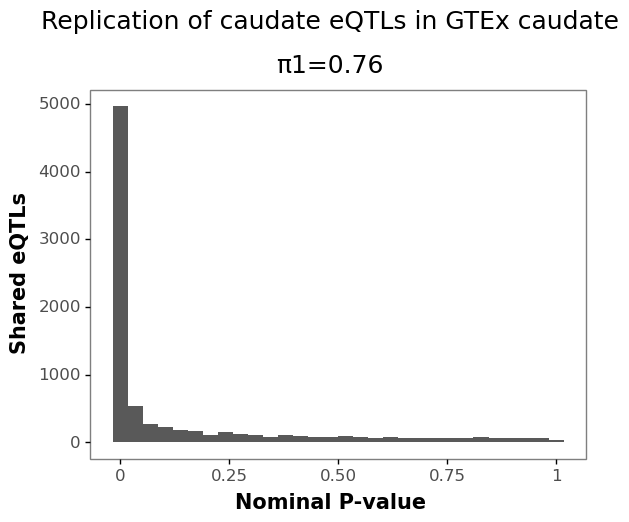

<ggplot: (8789721529594)>

In [8]:
p = (ggplot(df, aes(x='gtex_pval_nominal'))
     + geom_histogram(bins=30)
     + ggtitle('Replication of caudate eQTLs in GTEx caudate\n\nπ1=%.2f' % (pi1))
     + ylab('Shared eQTLs') + xlab('Nominal P-value') + theme_bw(base_size=15)
     + theme(panel_grid=element_blank(), axis_title=element_text(face="bold"))
)
display(p)

In [9]:
p.save('replication_of_LIBD_caudate_eQTLs_in_GTEx_caudate.pdf')

/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: replication_of_LIBD_caudate_eQTLs_in_GTEx_caudate.pdf


# Fraction of eQTLs with concordant directionality in the top π1 fraction of shared eQTLs

In [10]:
dfd = df.sort_values('gtex_pval_nominal').head(int(pi1 * len(df)))
fraction_same_directionality = np.sum(np.sign(dfd['gtex_slope']) == np.sign(dfd['libd_slope'])) / len(dfd)
fraction_same_directionality
print(f'Shared eQTLs: {len(df)}')
print(f'Top π1 shared eQTLs significant in GTEx: {len(dfd)}')
print(f'Fraction of top π1 shared eQTLs with concordant directionality: {fraction_same_directionality}')

Shared eQTLs: 8333
Top π1 shared eQTLs significant in GTEx: 6349
Fraction of top π1 shared eQTLs with concordant directionality: 0.9673964403843125


# Fraction of eQTLs with concordant directionality in the shared eQTLs that are statistically significant in GTEx

In [11]:
dfs = df.merge(gtex_sig_eqtl[['gene_id', 'variant_id']], left_on=['gene_id', 'gtex_variant_id'], right_on=['gene_id', 'variant_id'])
print(f'Shared eQTLs: {len(df)}')
print(f'Shared eQTLs significant in GTEx: {len(dfs)}')
f = np.sum(np.sign(dfs['gtex_slope']) == np.sign(dfs['libd_slope'])) / len(dfs)
print(f'Fraction of Shared eQTLs significant in GTEx with concordant directionality: {f}')

Shared eQTLs: 8333
Shared eQTLs significant in GTEx: 3134
Fraction of Shared eQTLs significant in GTEx with concordant directionality: 0.9926611359285259
